In [1]:
#Import Packages

In [ ]:
import sys
!{sys.executable} -m pip install yfinance --upgrade
!{sys.executable} -m pip install numpy --upgrade
!{sys.executable} -m pip install matplotlib --upgrade
!{sys.executable} -m pip install seaborn --upgrade
!{sys.executable} -m pip install pandas --upgrade
!{sys.executable} -m pip install yahoofinancials --upgrade
!{sys.executable} -m pip install sklearn --upgrade

In [ ]:
#Import Libraries

In [23]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [ ]:
#Define Functions

In [24]:
def enrich_stock_with_smas(stock_pd):
    stock_pd["SMA2"] = stock_pd['Close'].rolling(window=2).mean()
    stock_pd["SMA5"] = stock_pd['Close'].rolling(window=5).mean()
    stock_pd["SMA10"] = stock_pd['Close'].rolling(window=10).mean()
    stock_pd["SMA25"] = stock_pd['Close'].rolling(window=25).mean()
    stock_pd["SMA50"] = stock_pd['Close'].rolling(window=50).mean()
    stock_pd["SMA90"] = stock_pd['Close'].rolling(window=90).mean()
    stock_pd["SMA120"] = stock_pd['Close'].rolling(window=120).mean()
    stock_pd["SMA180"] = stock_pd['Close'].rolling(window=180).mean()
    e_stock_pd = stock_pd
    return e_stock_pd

def enrich_stock_with_bbs(stock_pd):
    #Bollinger Bands
    stock_pd['EWMA'] = stock_pd['Close'].ewm(halflife=0.5, min_periods=20).mean()
    stock_pd['middle_band'] = stock_pd['Close'].rolling(window=20).mean()
    stock_pd['upper_band'] = stock_pd['Close'].rolling(window=20).mean() + stock_pd['Close'].rolling(window=20).std()*2
    stock_pd['lower_band'] = stock_pd['Close'].rolling(window=20).mean() - stock_pd['Close'].rolling(window=20).std()*2
    e_stock_pd = stock_pd
    return e_stock_pd

def print_sma_chart_days(stock_ticker, stock_pd, nDays):
    dt_latest = stock_pd.iloc[-1:].index[0]
    dt_previous = dt_latest - timedelta(days=nDays)
    plt.figure(figsize=(12,10))
    plt.plot(stock_pd['SMA2'], 'r--', label="SMA2")
    plt.plot(stock_pd['SMA5'], 'y--', label="SMA5")
    plt.plot(stock_pd['SMA10'], 'g--', label="SMA10")
    plt.plot(stock_pd['SMA50'], 'c--', label="SMA50")
    plt.plot(stock_pd['SMA90'], 'm--', label="SMA90")
    plt.plot(stock_pd['SMA180'], 'b--', label="SMA180")
    plt.plot(stock_pd['Close'], label="Close")
    plt.title("["+stock_ticker+"] "+"Stock Price with SMAs from ["+dt_previous.strftime("%Y-%m-%d")+" to "+dt_latest.strftime("%Y-%m-%d")+"]")
    plt.xlabel("Date")
    plt.ylabel("Price [$]")
    plt.ylim(bottom=0)
    plt.xlim([dt_previous.strftime("%Y-%m-%d"), dt_latest.strftime("%Y-%m-%d")])
    plt.legend()
    plt.show()
    stock_graph_name = stock_ticker+"_"+dt_previous.strftime("%Y-%m-%d")+"_"+dt_latest.strftime("%Y-%m-%d")+".png"
    plt.savefig(r'stock_graphs/'+stock_graph_name)
    print("Saved Graph as: ["+ stock_graph_name+"]")

def last_stock_date(stock_pd):
    return stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")
    
def first_stock_date(stock_pd):
    return stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")

def save_dataframe_as_csv(stock_pd,stock_ticker):
    stock_file_name = stock_ticker+"_"+stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")+"_"+stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")+".csv"
    stock_pd.to_csv(r'stock_files/'+stock_file_name)
    print("Saved DataFrame as: ["+ stock_file_name+"]")

def convert_df_to_pd(stock_df):
    stock_pd = pd.DataFrame(stock_df)
    return stock_pd

def online_process_stock_once(stock_ticker):
    stock_df = yf.download(stock_ticker)
    stock_pd = convert_df_to_pd(stock_df)
    stock_pd = enrich_stock_with_smas(stock_pd)
    stock_pd = enrich_stock_with_bbs(stock_pd)
    save_dataframe_as_csv(stock_pd,stock_ticker)
    print_sma_chart_days(stock_ticker,stock_pd,90)
    
def get_list_of_files_in_dir(dir_name):
    list_of_files_only = [f for f in listdir(dir_name) if isfile(join(dir_name, f))]
    return list_of_files_only

In [ ]:
### PRODUCTION TRY ONE
tickers_to_iterate = ['TSLA']
for ticker_name in tickers_to_iterate:
    process_stock_once(ticker_name)

In [25]:
### Experimental
print(get_list_of_files_in_dir('stock_files'))

['DBX_2018-03-23_2020-07-02.csv', 'AMZN_1997-05-15_2020-07-02.csv', 'SNAP_2017-03-02_2020-07-02.csv', 'AAPL_1980-12-12_2020-07-02.csv', 'QCOM_1991-12-13_2020-07-02.csv', 'FB_2012-05-18_2020-07-02.csv', 'UBER_2019-05-10_2020-07-02.csv', 'NVDA_1999-01-22_2020-07-02.csv', 'AMD_1980-03-17_2020-07-02.csv', 'MU_1984-06-01_2020-07-02.csv', 'GOOG_2004-08-19_2020-07-02.csv', 'INTC_1980-03-17_2020-07-02.csv', 'CRM_2004-06-23_2020-07-02.csv', 'ADBE_1986-08-13_2020-07-02.csv', 'TSLA_2010-06-29_2020-07-02.csv', 'WORK_2019-06-20_2020-07-02.csv', 'MSFT_1986-03-13_2020-07-02.csv', 'GOOGL_2004-08-19_2020-07-02.csv', 'SHOP_2015-05-20_2020-07-02.csv']


[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [TSLA_2010-06-29_2020-07-02.csv]


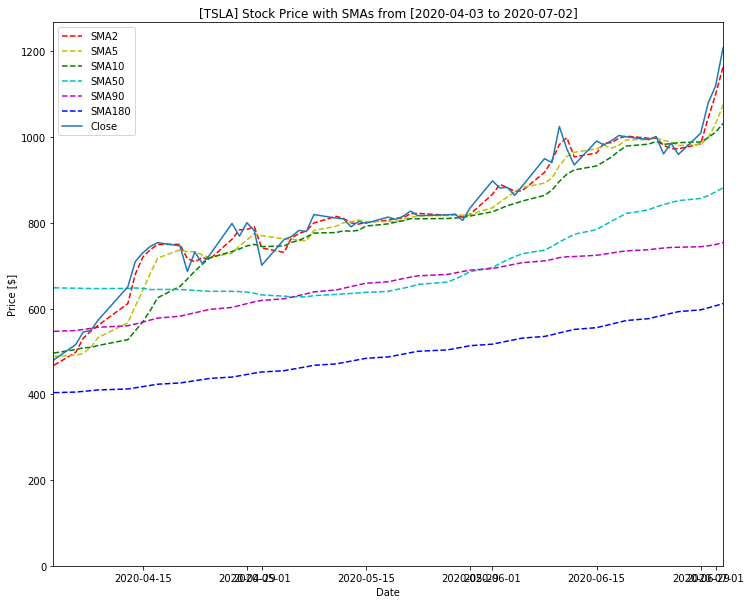

Saved Graph as: [TSLA_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [GOOG_2004-08-19_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

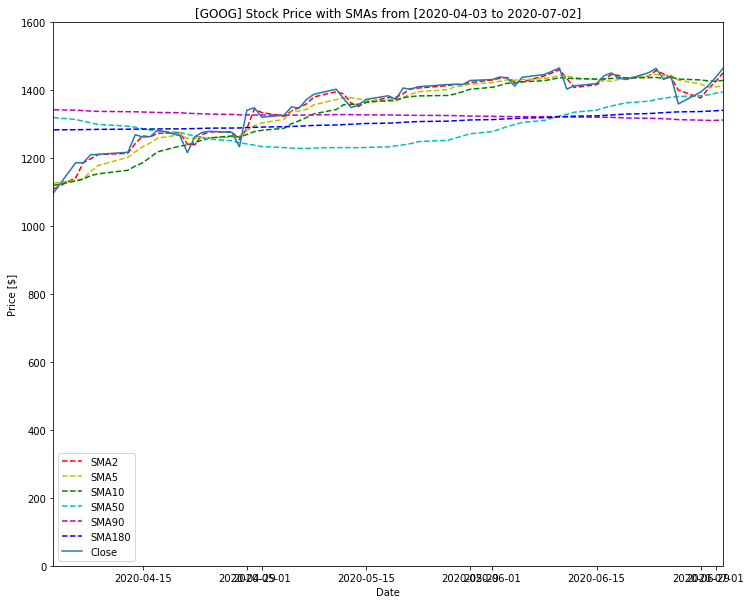

Saved Graph as: [GOOG_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [AMZN_1997-05-15_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

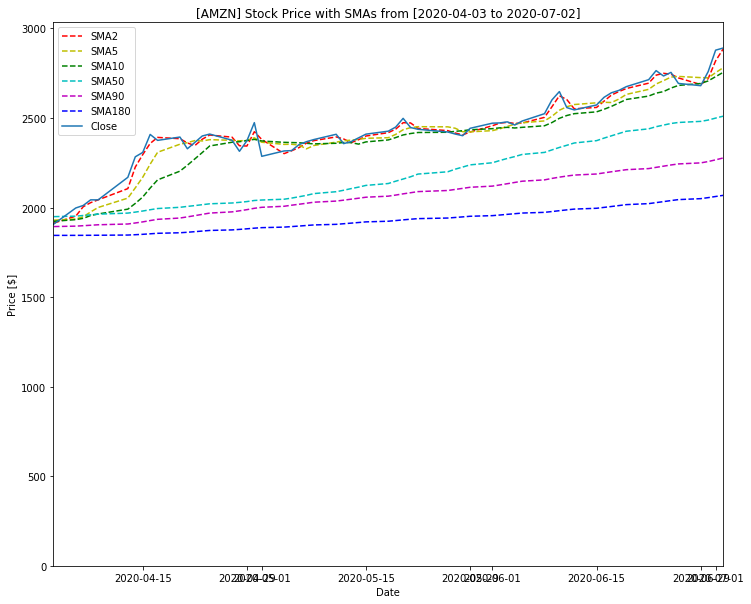

Saved Graph as: [AMZN_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [AAPL_1980-12-12_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

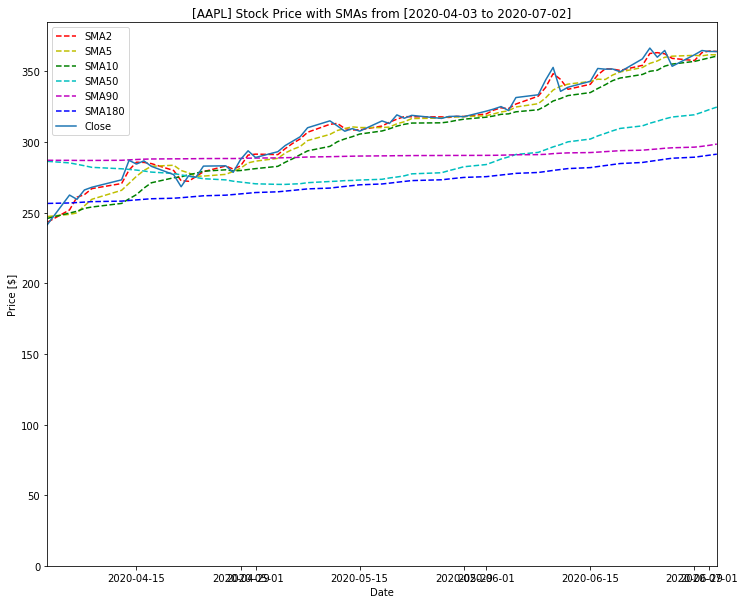

Saved Graph as: [AAPL_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [MSFT_1986-03-13_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

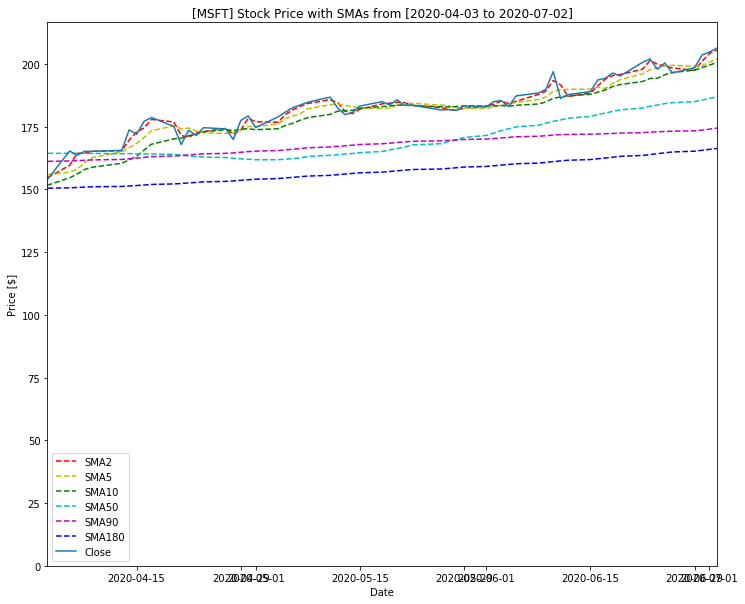

Saved Graph as: [MSFT_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [FB_2012-05-18_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

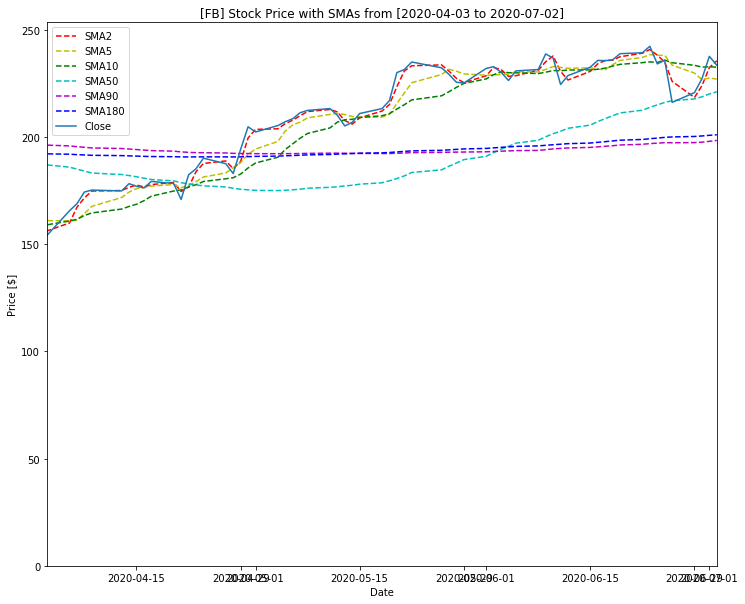

Saved Graph as: [FB_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [UBER_2019-05-10_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

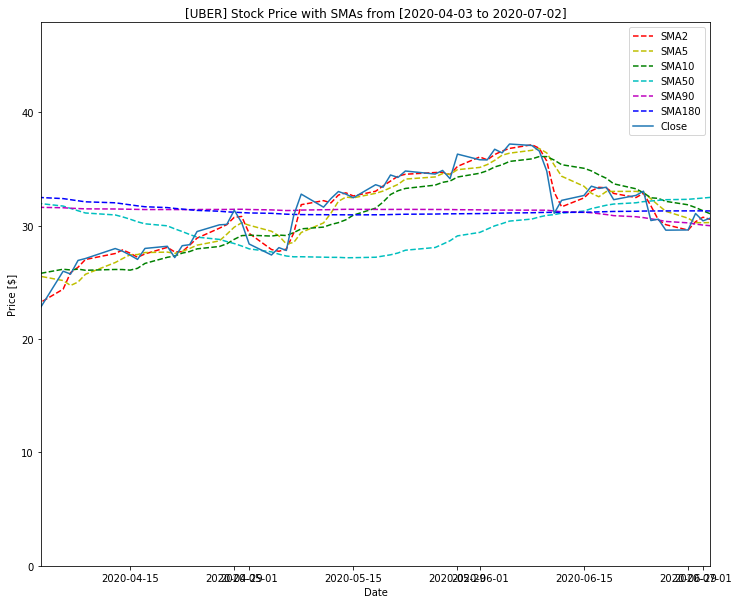

Saved Graph as: [UBER_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [SNAP_2017-03-02_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

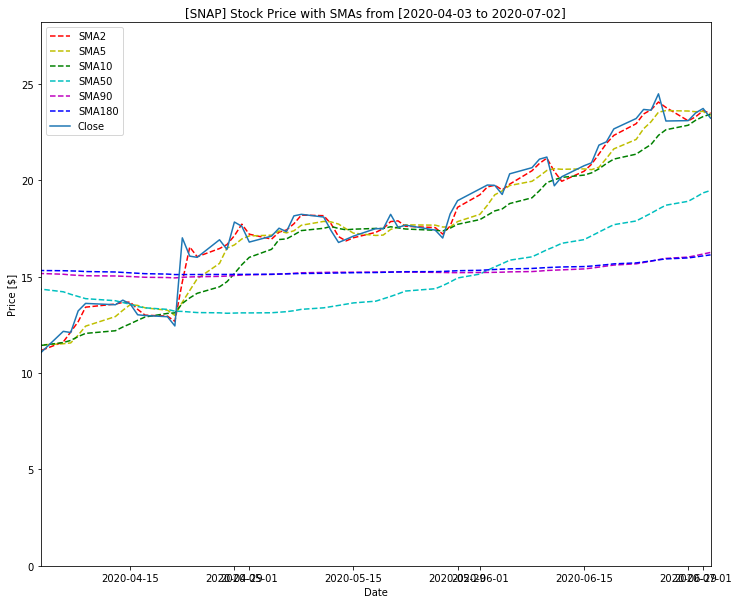

Saved Graph as: [SNAP_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [NVDA_1999-01-22_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

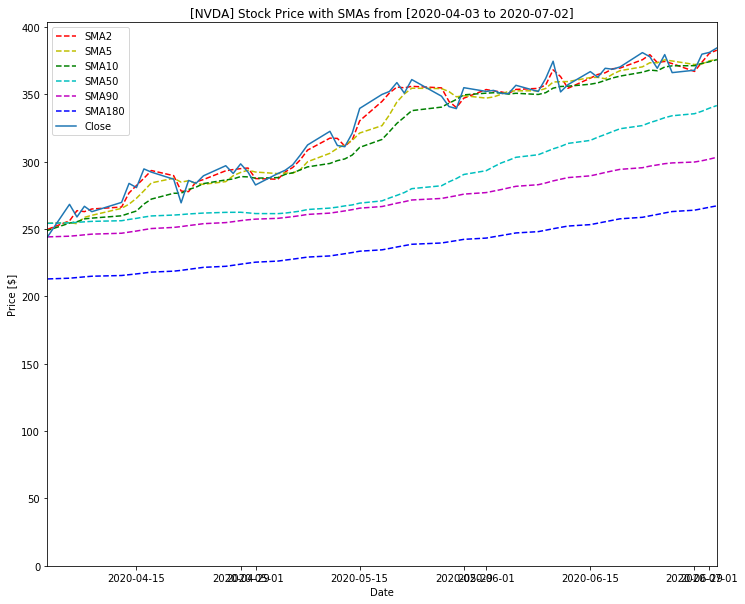

Saved Graph as: [NVDA_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [AMD_1980-03-17_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

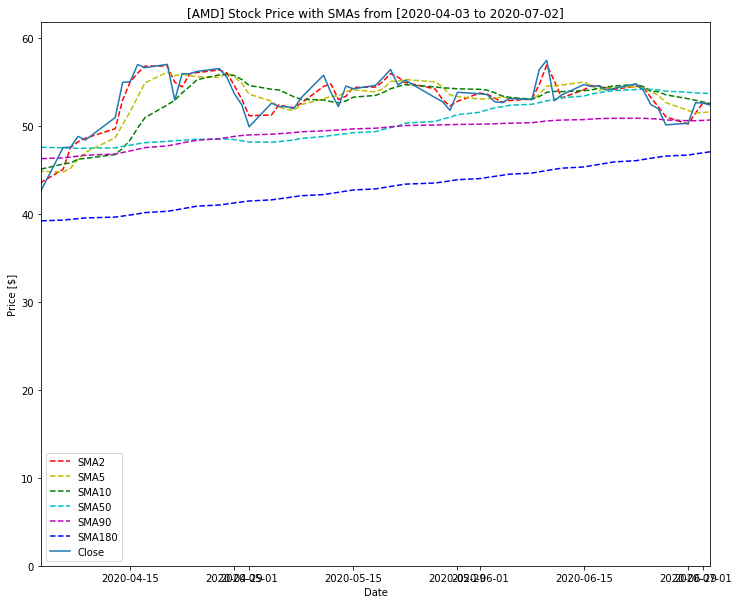

Saved Graph as: [AMD_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [GOOGL_2004-08-19_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

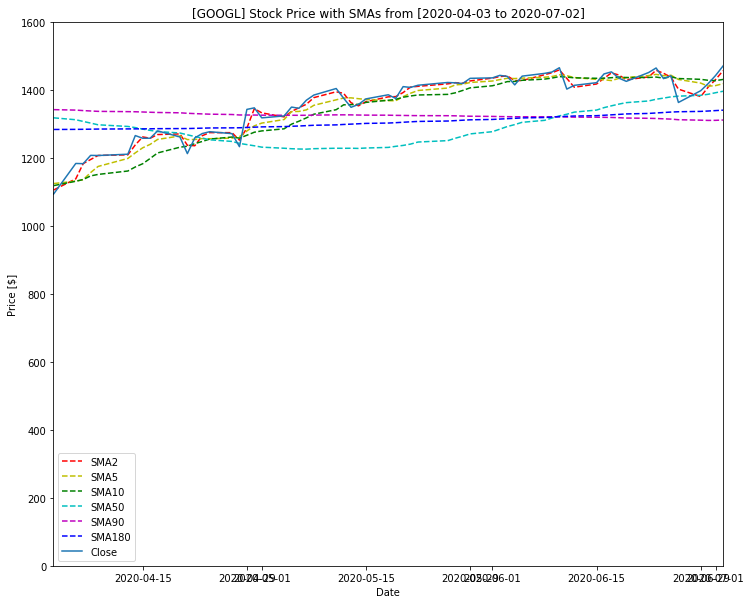

Saved Graph as: [GOOGL_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [WORK_2019-06-20_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

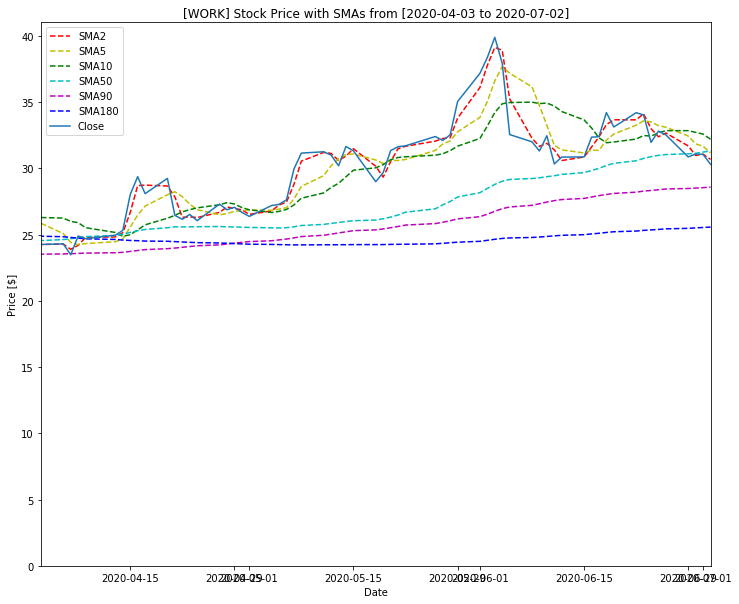

Saved Graph as: [WORK_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [SHOP_2015-05-20_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

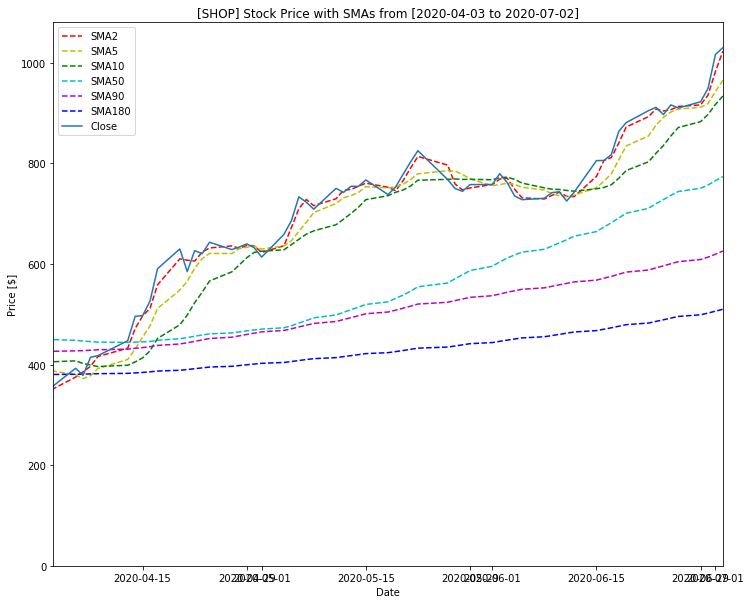

Saved Graph as: [SHOP_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [CRM_2004-06-23_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

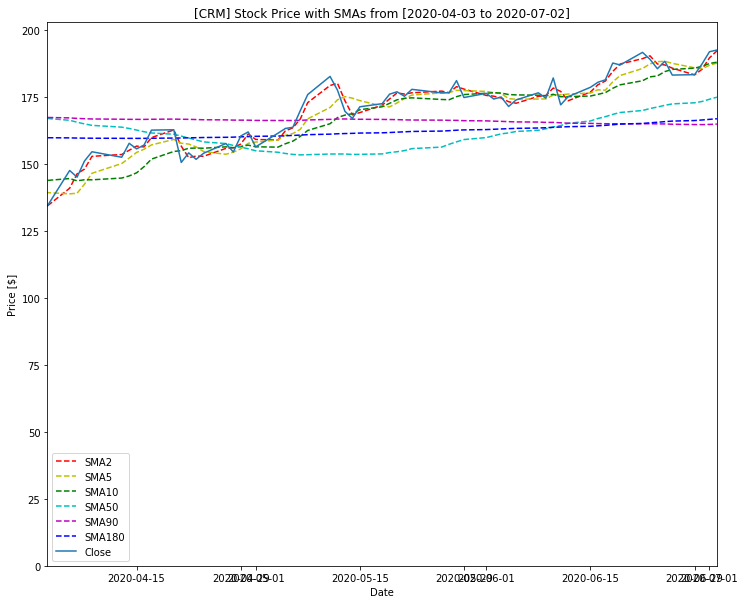

Saved Graph as: [CRM_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [ADBE_1986-08-13_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

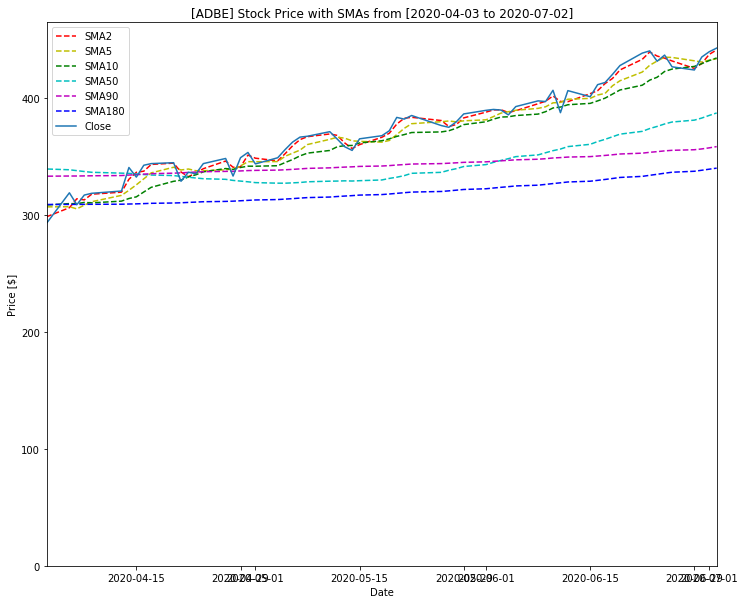

Saved Graph as: [ADBE_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [DBX_2018-03-23_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

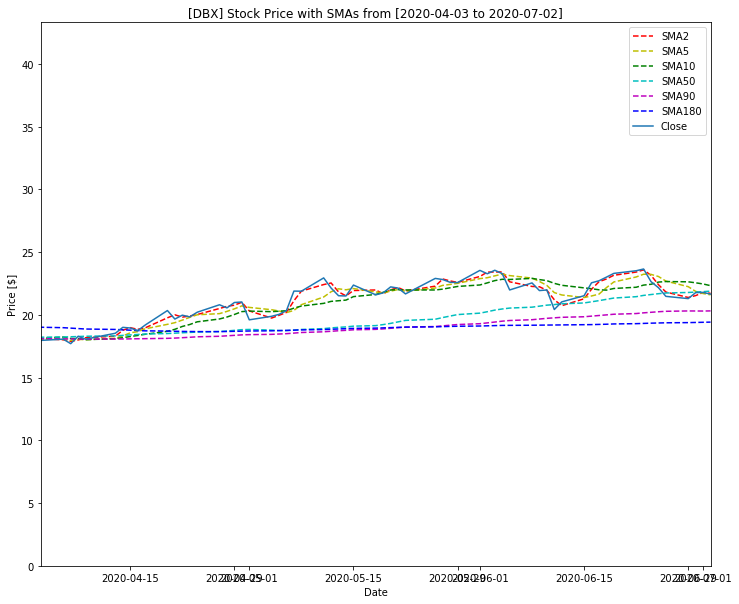

Saved Graph as: [DBX_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [INTC_1980-03-17_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

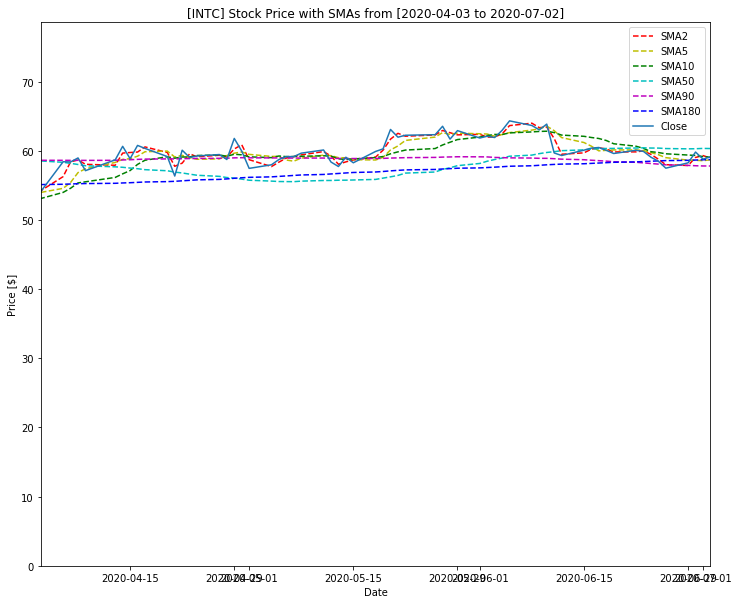

Saved Graph as: [INTC_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [QCOM_1991-12-13_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

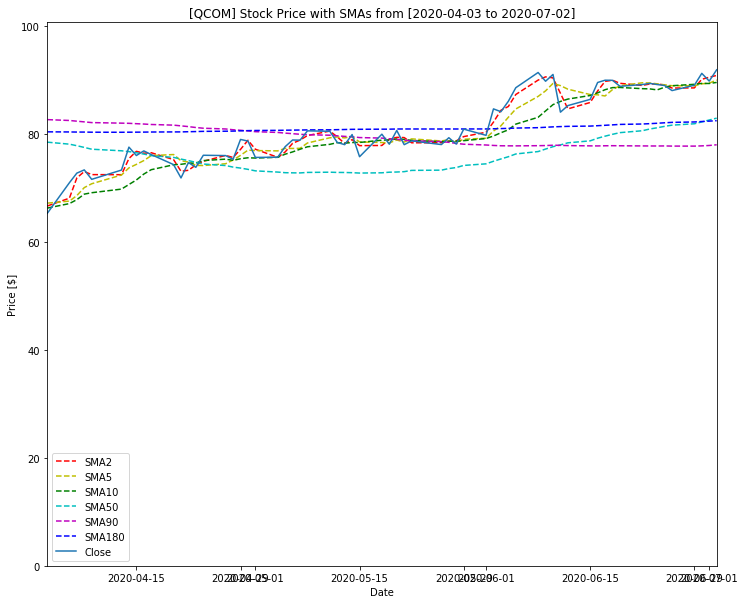

Saved Graph as: [QCOM_2020-04-03_2020-07-02.png]
[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [MU_1984-06-01_2020-07-02.csv]


<Figure size 432x288 with 0 Axes>

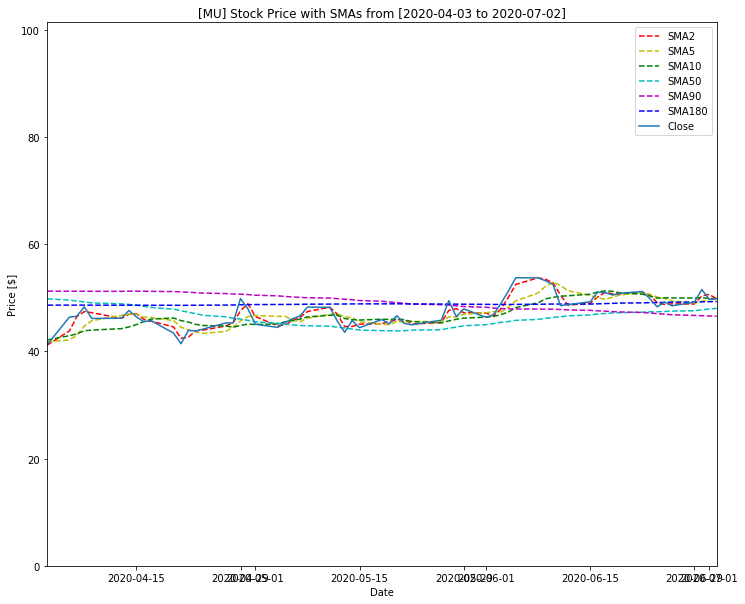

Saved Graph as: [MU_2020-04-03_2020-07-02.png]


<Figure size 432x288 with 0 Axes>

In [22]:
### PRODUCTION EXPERIMENTATION
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
for ticker_name in tickers_to_iterate:
    online_process_stock_once(ticker_name)